In [27]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
from __init__ import *
import numpy as np
from export.saver import read_pickle, save_pickle
from read.svg_reader import SVGReader
from helpers.helpers import filter_none
from placement2.attract import *
from visuals.plotter import plot_general
from copy import deepcopy
import networkx as nx
from itertools import pairwise, accumulate, product
from functools import reduce
from operator import add
from helpers.helpers import sort_and_group_objects
from domains.domain import Domain
from placement2.neighbors import *
from placement2.connectivity import *
from fixes.id_problems import report_problems
from new_solutions.selection import *
from helpers.layout import Layout
import plotly.io as pio


In [29]:
# layout: Layout = read_pickle("overlap_1011")
# layout

Layout(domains={'bedroom_1': Domain(bedroom_1, x=[0.00-3.22], y=[3.15-5.95]), 'kitchen': Domain(kitchen, x=[3.22-5.02], y=[0.00-2.24]), 'm_bath': Domain(m_bath, x=[4.82-7.34], y=[4.38-5.68]), 'm_bedroom': Domain(m_bedroom, x=[7.34-9.47], y=[3.15-5.89]), 'm_closet': Domain(m_closet, x=[8.38-9.38], y=[2.36-3.15]), 'bath': Domain(bath, x=[5.02-7.34], y=[3.15-4.38]), 'dining': Domain(dining, x=[5.02-8.38], y=[0.00-3.15]), 'transit_space': Domain(transit_space, x=[3.22-5.02], y=[2.24-4.02]), 'closet': Domain(closet, x=[8.38-9.38], y=[-0.05-2.36]), 'bedroom_2': Domain(bedroom_2, x=[0.00-3.22], y=[0.00-3.15]), 'laundry': Domain(laundry, x=[3.22-5.02], y=[4.02-5.77])}, graphs=DiGraphs(Gx=<networkx.classes.digraph.DiGraph object at 0x1115c97b0>, Gy=<networkx.classes.digraph.DiGraph object at 0x1115c9090>))

In [30]:
# plot_general(layout.domains)

In [35]:
# report_problems(layout)[0].action_details

[laundry-WEST-0.20, m_bath-EAST-0.20]

In [74]:
case  = "amber_c_f01.svg"
sv = SVGReader(case)
sv.run()
# ag = AdjacencyGenerator(sv.layout, buffer_size=0.17)
# ag.run() # TODO shouldnt run if sv.layout is empty
# ag.draw_graph()
domains = sv.layout.domains
pos = create_pos(domains)


No reference for svg to meters conversion!! 


In [75]:
plot_general(sv.layout.domains)


In [76]:
ad, graphs = adjust_domains(domains)
Gx, Gy = graphs

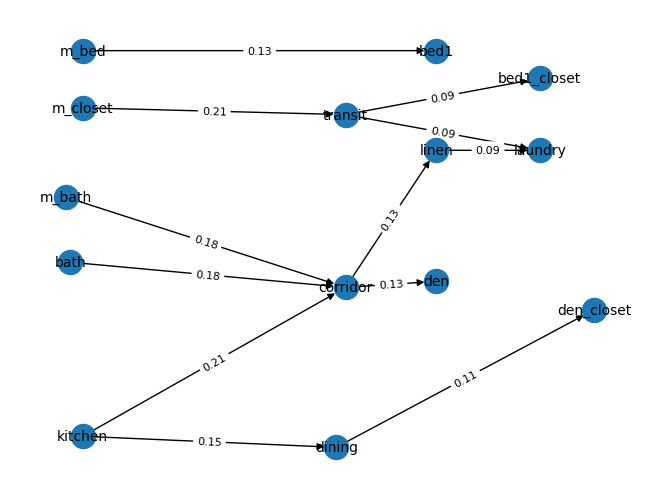

In [77]:
draw_digraph(Gx, domains=domains)

## running fixer

In [78]:
plot_general(ad)

In [79]:
report_problems(Layout(ad, graphs))

[Problem(ix=0, HOLE, ['kitchen', 'corridor'], resolved=False,  n_actions=2,
 Problem(ix=1, HOLE, ['linen', 'laundry'], resolved=False,  n_actions=2,
 Problem(ix=2, HOLE, ['bed1_closet', 'bed1'], resolved=False,  n_actions=2,
 Problem(ix=3, HOLE, ['m_closet', 'm_bed'], resolved=False,  n_actions=2,
 Problem(ix=4, HOLE, ['linen', 'transit'], resolved=False,  n_actions=2]

In [80]:
playout = Layout(ad, graphs)

In [81]:
re = Reporter(playout)
re.run()

In [82]:
c = Cook(re)

initializing.. 0
running again -> 1
next best layout m_closet-STRETCH-for-HOLE near ['m_closet', 'm_bed']4-PS:2.22-S:3.11


In [83]:
c.run_again()

running again -> 2
next best layout bed1_closet-STRETCH-for-HOLE near ['bed1_closet', 'bed1']3-PS:1.12-S:2.06


In [84]:
c.run_again()

running again -> 3
next best layout linen-STRETCH-for-HOLE near ['linen', 'transit']2-PS:1.00-S:1.50


In [85]:
c.run_again()

running again -> 4
next best layout linen-STRETCH-for-HOLE near ['linen', 'laundry']1-PS:0.26-S:0.63


In [86]:
c.run_again()

running again -> 5
next best layout kitchen-PULL-for-HOLE near ['kitchen', 'corridor']1-PS:0.12-S:0.56


In [94]:
c.run_again()

No more results!


In [95]:
c.plot_all()

n_rows 3, n_sols: 6
len sols = 6+1. Len indices = 9


In [93]:
c.bl_hist[-1]

node: dining, action: SQUEEZE, summary: Counter(), # unres probs: 0

In [96]:
plot_general(c.bl_hist[-1].layout.domains)

In [98]:
res_doms = c.bl_hist[-1].layout.domains
res_doms

{'m_bed': Domain(m_bed, x=[0.11-2.24], y=[8.69-11.14]),
 'bed1_closet': Domain(bed1_closet, x=[2.73-3.88], y=[8.16-8.69]),
 'transit': Domain(transit, x=[1.58-2.73], y=[7.73-8.69]),
 'm_closet': Domain(m_closet, x=[0.11-1.58], y=[7.26-8.69]),
 'laundry': Domain(laundry, x=[2.73-3.88], y=[7.07-8.16]),
 'den': Domain(den, x=[2.06-3.87], y=[5.02-7.07]),
 'kitchen': Domain(kitchen, x=[0.14-1.61], y=[2.42-5.09]),
 'living': Domain(living, x=[0.11-3.27], y=[0.00-2.42]),
 'dining': Domain(dining, x=[1.61-3.12], y=[2.42-5.02]),
 'den_closet': Domain(den_closet, x=[3.12-3.92], y=[4.66-5.02]),
 'm_bath': Domain(m_bath, x=[0.00-1.61], y=[6.02-7.26]),
 'bath': Domain(bath, x=[0.03-1.61], y=[5.09-6.02]),
 'linen': Domain(linen, x=[2.06-2.73], y=[7.07-7.73]),
 'corridor': Domain(corridor, x=[1.61-2.06], y=[5.02-7.73]),
 'bed1': Domain(bed1, x=[2.24-4.05], y=[8.69-11.14])}

In [118]:
m_bed = res_doms["m_bed"]
bed_closet = res_doms["bed1_closet"]

a = not m_bed.y.line_string.disjoint(bed_closet.y.line_string)
b = not m_bed.y.line_string.touches(bed_closet.y.line_string)
a and b 

False

In [117]:
corr = res_doms["corridor"]
m_clos = res_doms["m_closet"]
a = not m_clos.y.line_string.disjoint(corr.y.line_string)
b = not m_clos.y.line_string.touches(corr.y.line_string)
a and b

True

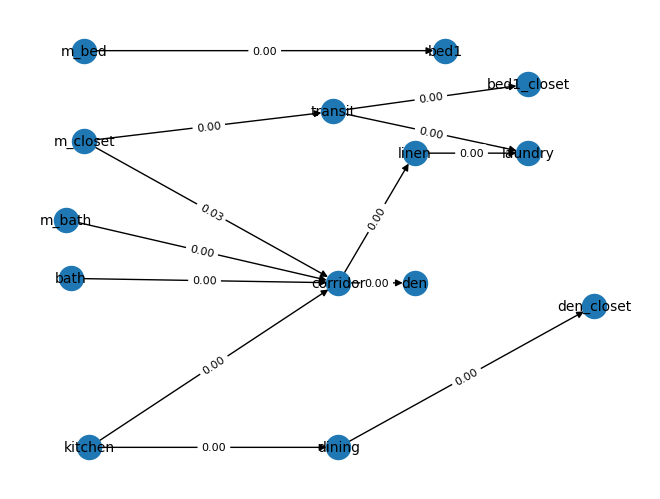

In [119]:
Gx2 = create_graph(res_doms, "x") 
draw_digraph(Gx2, domains=res_doms)

In [91]:
# save_pickle(c.bl_hist[-1].layout, "overlap_1011")